UNIVERSIDADE ESTADUAL DO CEARÁ \
MESTRADO ACADÊMICO EM CIÊNCIA DA COMPUTAÇÃO \
MINERAÇÃO MASSIVA DE DADOS

Daniel Gleison Moreira Lira \
daniel.gleison@aluno.uece.br

---
# Mecanismo de predição de fraudes financeiras utilizando aprendizado de máquina e processamento distribuído
---


## Dataset

https://www.kaggle.com/ntnu-testimon/paysim1

PS_20174392719_1491204439457_log.csv\
Date created: 2017-03-31

### Predicted attribute:
Class of fraud detection

### Number of Instances:
6.353.307

### Number of Attributes:
11 attributes (5 Decimal, 3 Integer, 3 String)

### Attribute Information:

This is a sample of 1 row with headers explanation:

1,PAYMENT,1060.31,C429214117,1089.0,28.69,M1591654462,0.0,0.0,0,0

step - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

type - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

amount - amount of the transaction in local currency.

nameOrig - customer who started the transaction

oldbalanceOrg - initial balance before the transaction

newbalanceOrig - new balance after the transaction

nameDest - customer who is the recipient of the transaction

oldbalanceDest - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

newbalanceDest - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

isFraud - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

isFlaggedFraud - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

### Missing Attribute Values: 
None

### Class Distribution: 
2 Classes \
6.354.407 without fraud and 8.213 with fraud

---

In [1]:
# Spark Lib
import findspark
findspark.init()

In [2]:
# Load libraries
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import isnull, when, count, col

from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.feature import StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.util import MLUtils

from pyspark.ml.feature import StringIndexer, IndexToString
from pyspark.ml.feature import VectorAssembler, VectorIndexer

from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import LinearSVC, OneVsRest

from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator

from pyspark.ml.linalg import Vectors
from pyspark.mllib.util import MLUtils

## SKLearn Lib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score
from joblib import dump, load
import pickle


import time
start_time = time.time()
%matplotlib inline

## Criação do ambiente Spark

In [3]:
spark = SparkSession.builder \
        .master("local[*]") \
        .appName("MachineLearningFraud") \
        .getOrCreate()
spark

## Importação e compreensão dos dados

In [4]:
data_path='./data/'
df_original = spark.read.format('csv')\
                   .options(sep=',',header='true',inferschema='true').\
                   load(data_path+'PS_20174392719_1491204439457_log.csv')
df_original.show()

+----+--------+---------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+
|step|    type|   amount|   nameOrig|oldbalanceOrg|newbalanceOrig|   nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|
+----+--------+---------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+
|   1| PAYMENT|  9839.64|C1231006815|     170136.0|     160296.36|M1979787155|           0.0|           0.0|      0|             0|
|   1| PAYMENT|  1864.28|C1666544295|      21249.0|      19384.72|M2044282225|           0.0|           0.0|      0|             0|
|   1|TRANSFER|    181.0|C1305486145|        181.0|           0.0| C553264065|           0.0|           0.0|      1|             0|
|   1|CASH_OUT|    181.0| C840083671|        181.0|           0.0|  C38997010|       21182.0|           0.0|      1|             0|
|   1| PAYMENT| 11668.14|C2048537720|      41554.0|      29885.86|M123070170

## Balanceamento do dataset

In [5]:
df0 = df_original[df_original.isFraud==0]
df1 = df_original[df_original.isFraud==1]
df0.groupby('isFraud').count().show()
df1.groupby('isFraud').count().show()

+-------+-------+
|isFraud|  count|
+-------+-------+
|      0|6354407|
+-------+-------+

+-------+-----+
|isFraud|count|
+-------+-----+
|      1| 8213|
+-------+-----+



In [6]:
guessedFraction = 1.0
noOfSamples = df1.count()
df0 = df0.sample(True, guessedFraction).limit(noOfSamples)
df0.groupby('isFraud').count().show()

+-------+-----+
|isFraud|count|
+-------+-----+
|      0| 8213|
+-------+-----+



In [7]:
df_balanceado = df0.union(df1)
df_balanceado.count()

16426

## Análise exploratória dos dados

In [8]:
df_original = df_balanceado

In [9]:
df_original.printSchema()

root
 |-- step: integer (nullable = true)
 |-- type: string (nullable = true)
 |-- amount: double (nullable = true)
 |-- nameOrig: string (nullable = true)
 |-- oldbalanceOrg: double (nullable = true)
 |-- newbalanceOrig: double (nullable = true)
 |-- nameDest: string (nullable = true)
 |-- oldbalanceDest: double (nullable = true)
 |-- newbalanceDest: double (nullable = true)
 |-- isFraud: integer (nullable = true)
 |-- isFlaggedFraud: integer (nullable = true)



In [10]:
df_original.count()

16426

In [11]:
df_original.groupBy('IsFraud').count().show()

+-------+-----+
|IsFraud|count|
+-------+-----+
|      1| 8213|
|      0| 8213|
+-------+-----+



In [12]:
df_original.groupBy('isFlaggedFraud').count().show()

+--------------+-----+
|isFlaggedFraud|count|
+--------------+-----+
|             1|   16|
|             0|16410|
+--------------+-----+



### Estatística descritiva

In [13]:
df_original.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
step,16426,186.0233166930476,238.0792153027866,1,743
type,16426,None,None,CASH_IN,TRANSFER
amount,16426,784727.7085468163,1839630.8982522383,0.0,1.0E7
nameOrig,16426,None,None,C1000036340,C999864329
oldbalanceOrg,16426,1284608.1605466937,2969170.076606432,0.0,5.958504037E7
newbalanceOrig,16426,569293.4797577027,2140225.0867706854,0.0,4.958504037E7
nameDest,16426,None,None,C1000039615,M999221400
oldbalanceDest,16426,778124.3870461485,3081242.623673352,0.0,2.3623051682E8
newbalanceDest,16426,1237570.697896019,3566922.0427193088,0.0,2.3672649466E8


### Identificação de valores ausentes

In [14]:
df_original.select([count(when(isnull(c), c)).alias(c) for c in df_original.columns]).show()

+----+----+------+--------+-------------+--------------+--------+--------------+--------------+-------+--------------+
|step|type|amount|nameOrig|oldbalanceOrg|newbalanceOrig|nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|
+----+----+------+--------+-------------+--------------+--------+--------------+--------------+-------+--------------+
|   0|   0|     0|       0|            0|             0|       0|             0|             0|      0|             0|
+----+----+------+--------+-------------+--------------+--------+--------------+--------------+-------+--------------+



### Matrix de correlação

In [15]:
df_original.toPandas().corr()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
step,1.000000,0.313246,0.128546,-0.110535,-0.048694,0.023170,0.766115,0.046107
amount,0.313246,1.000000,0.721365,0.145564,-0.007684,0.247215,0.371412,0.069201
oldbalanceOrg,0.128546,0.721365,1.000000,0.784466,0.057673,0.187867,0.122954,0.068709
newbalanceOrig,-0.110535,0.145564,0.784466,1.000000,0.115900,0.075829,-0.176109,0.105758
oldbalanceDest,-0.048694,-0.007684,0.057673,0.115900,1.000000,0.898623,-0.075905,-0.007886
newbalanceDest,0.023170,0.247215,0.187867,0.075829,0.898623,1.000000,0.011814,-0.010834
isFraud,0.766115,0.371412,0.122954,-0.176109,-0.075905,0.011814,1.000000,0.031225
isFlaggedFraud,0.046107,0.069201,0.068709,0.105758,-0.007886,-0.010834,0.031225,1.000000


## Transformação do dataset

### Indexação dos atributos

In [16]:
indexer = StringIndexer(inputCol='type', outputCol='indexType').fit(df_original)
df_indexado = indexer.transform(df_original)

indexer = StringIndexer(inputCol='isFraud', outputCol='label').fit(df_original)
df_indexado = indexer.transform(df_indexado)

labelReverse = IndexToString().setInputCol('label')
indexTypeReverse = IndexToString().setInputCol('indexType')

df_indexado.show(5)

+----+-------+--------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+---------+-----+
|step|   type|  amount|   nameOrig|oldbalanceOrg|newbalanceOrig|   nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|indexType|label|
+----+-------+--------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+---------+-----+
|   1|PAYMENT| 1864.28|C1666544295|      21249.0|      19384.72|M2044282225|           0.0|           0.0|      0|             0|      2.0|  0.0|
|   1|PAYMENT|11668.14|C2048537720|      41554.0|      29885.86|M1230701703|           0.0|           0.0|      0|             0|      2.0|  0.0|
|   1|PAYMENT|11668.14|C2048537720|      41554.0|      29885.86|M1230701703|           0.0|           0.0|      0|             0|      2.0|  0.0|
|   1|PAYMENT| 7107.77| C154988899|     183195.0|     176087.23| M408069119|           0.0|           0.0|      0|          

### Exclusão de atributos

In [17]:
df_selecionado = df_indexado.drop('type','nameOrig','nameDest','isFraud','isFlaggedFraud')
df_selecionado.show(5)

+----+--------+-------------+--------------+--------------+--------------+---------+-----+
|step|  amount|oldbalanceOrg|newbalanceOrig|oldbalanceDest|newbalanceDest|indexType|label|
+----+--------+-------------+--------------+--------------+--------------+---------+-----+
|   1| 1864.28|      21249.0|      19384.72|           0.0|           0.0|      2.0|  0.0|
|   1|11668.14|      41554.0|      29885.86|           0.0|           0.0|      2.0|  0.0|
|   1|11668.14|      41554.0|      29885.86|           0.0|           0.0|      2.0|  0.0|
|   1| 7107.77|     183195.0|     176087.23|           0.0|           0.0|      2.0|  0.0|
|   1| 7107.77|     183195.0|     176087.23|           0.0|           0.0|      2.0|  0.0|
+----+--------+-------------+--------------+--------------+--------------+---------+-----+
only showing top 5 rows



## Seleção dos atributos

In [18]:
df_selecionado.show(5)

+----+--------+-------------+--------------+--------------+--------------+---------+-----+
|step|  amount|oldbalanceOrg|newbalanceOrig|oldbalanceDest|newbalanceDest|indexType|label|
+----+--------+-------------+--------------+--------------+--------------+---------+-----+
|   1| 1864.28|      21249.0|      19384.72|           0.0|           0.0|      2.0|  0.0|
|   1|11668.14|      41554.0|      29885.86|           0.0|           0.0|      2.0|  0.0|
|   1|11668.14|      41554.0|      29885.86|           0.0|           0.0|      2.0|  0.0|
|   1| 7107.77|     183195.0|     176087.23|           0.0|           0.0|      2.0|  0.0|
|   1| 7107.77|     183195.0|     176087.23|           0.0|           0.0|      2.0|  0.0|
+----+--------+-------------+--------------+--------------+--------------+---------+-----+
only showing top 5 rows



## Criação da matrix de classificação

In [19]:
ignore = ['label']
list = [x for x in df_selecionado.columns if x not in ignore]

assembler = VectorAssembler(
            inputCols= list,
            outputCol='features')

df_transformado = (assembler.transform(df_selecionado).select('label','features'))
df_transformado.show(truncate = False, n = 5)
df_transformado.count()

+-----+--------------------------------------------+
|label|features                                    |
+-----+--------------------------------------------+
|0.0  |[1.0,1864.28,21249.0,19384.72,0.0,0.0,2.0]  |
|0.0  |[1.0,11668.14,41554.0,29885.86,0.0,0.0,2.0] |
|0.0  |[1.0,11668.14,41554.0,29885.86,0.0,0.0,2.0] |
|0.0  |[1.0,7107.77,183195.0,176087.23,0.0,0.0,2.0]|
|0.0  |[1.0,7107.77,183195.0,176087.23,0.0,0.0,2.0]|
+-----+--------------------------------------------+
only showing top 5 rows



16426

## Divisão do dataset para treinamento e teste

In [20]:
train_sample = 0.7
test_sample = 0.3
seed = 1234

(train, test) = df_transformado.randomSplit([train_sample, test_sample],seed)

num_train = df_transformado.count() * train_sample
num_test = df_transformado.count() * test_sample

print('Percentual da base de treinamento', train_sample*100, '%')
print('Percentual da base de teste', test_sample*100, '%')
print('Quantidade de registros da base de treinamento:', train.count())
print('Quantidade de registros da base de treinamento:', test.count())

Percentual da base de treinamento 70.0 %
Percentual da base de teste 30.0 %
Quantidade de registros da base de treinamento: 11559
Quantidade de registros da base de treinamento: 4867


In [21]:
train.groupby('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|  0.0| 5773|
|  1.0| 5786|
+-----+-----+



In [22]:
test.groupby('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|  0.0| 2440|
|  1.0| 2427|
+-----+-----+



## Treinamento, teste e avaliação dos modelos de predição

### Decision Tree (DT)

In [23]:
# Treinamento do modelo de predição
start_time = time.time()
trainer = DecisionTreeClassifier(featuresCol='features', labelCol='label', predictionCol='prediction', probabilityCol='probability',\
                                 rawPredictionCol='rawPrediction', maxDepth=5, maxBins=32, minInstancesPerNode=1, minInfoGain=0.0,\
                                 maxMemoryInMB=256, cacheNodeIds=False, checkpointInterval=10, impurity='gini', seed=None)
model_dt = trainer.fit(train)
time_dt_train = time.time() - start_time

In [24]:
# Execução do modelo de predição na base de teste
start_time = time.time()
result_dt = model_dt.transform(test)
time_dt_pred = time.time() - start_time

In [25]:
# Cálculo da acurácia do modelo de predição
evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction',\
            metricName='accuracy')
accuracy_dt = evaluator.evaluate(result_dt) * 100

In [26]:
# Cálculo do recall do modelo de predição
evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction',\
            metricName='weightedRecall')
recall_dt = evaluator.evaluate(result_dt) * 100

In [27]:
# Cálculo da precisão do modelo de predição
evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction',\
            metricName='weightedPrecision')
precision_dt = evaluator.evaluate(result_dt) * 100

In [28]:
# Cálculo da F1 score do modelo de predição
evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction',\
            metricName='f1')
f1_dt = evaluator.evaluate(result_dt) * 100

In [29]:
# Matriz de confusão
y_true = result_dt.select("label").toPandas()
y_pred = result_dt.select("prediction").toPandas()
mc_dt = confusion_matrix(y_true, y_pred, labels = [0,1])
tn_dt, fp_dt, fn_dt, tp_dt = confusion_matrix(y_true, y_pred).ravel()
print(mc_dt)

[[2440    0]
 [  15 2412]]


In [30]:
fp_dt

0

In [99]:
np.sum(mc_dt)

4867

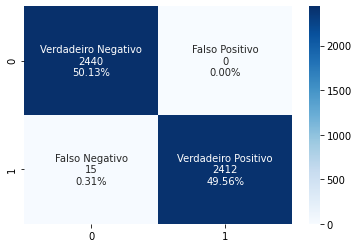

In [31]:
group_names = ['Verdadeiro Negativo','Falso Positivo','Falso Negativo','Verdadeiro Positivo']
group_counts = ['{0:0.0f}'.format(value) for value in mc_dt.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in mc_dt.flatten()/np.sum(mc_dt)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(mc_dt, annot=labels, fmt='', cmap='Blues')

In [32]:
# Exibição dos resultados
evaluator_dt = spark.createDataFrame(
    [(round(accuracy_dt,2), round(recall_dt,2), round(precision_dt,2), round(f1_dt,2),\
      int(fp_dt), int(fn_dt),\
      round(time_dt_train,2), round(time_dt_pred,2))],\
    ['acurácia','recall','precisão','f1 score',\
     'falso positivo', 'falso negativo',\
     'tempo treinamento','tempo predição'])
print("Resultados do modelo Decision Tree:")
evaluator_dt.show()

Resultados do modelo Decision Tree:
+--------+------+--------+--------+--------------+--------------+-----------------+--------------+
|acurácia|recall|precisão|f1 score|falso positivo|falso negativo|tempo treinamento|tempo predição|
+--------+------+--------+--------+--------------+--------------+-----------------+--------------+
|   99.69| 99.69|   99.69|   99.69|             0|            15|             8.95|          0.08|
+--------+------+--------+--------+--------------+--------------+-----------------+--------------+



In [33]:
result_dt.show(truncate = False, n = 5)

+-----+-------------------------------------+-------------+----------------------------------------+----------+
|label|features                             |rawPrediction|probability                             |prediction|
+-----+-------------------------------------+-------------+----------------------------------------+----------+
|0.0  |(7,[0,1,4],[1.0,10782.94,100585.0])  |[1128.0,16.0]|[0.986013986013986,0.013986013986013986]|0.0       |
|0.0  |(7,[0,1,4],[1.0,17851.54,32353.0])   |[1128.0,16.0]|[0.986013986013986,0.013986013986013986]|0.0       |
|0.0  |(7,[0,1,4],[1.0,26004.52,52251.58])  |[1128.0,16.0]|[0.986013986013986,0.013986013986013986]|0.0       |
|0.0  |(7,[0,1,4],[1.0,47913.58,51304.0])   |[1128.0,16.0]|[0.986013986013986,0.013986013986013986]|0.0       |
|0.0  |(7,[0,1,4],[1.0,193605.38,249452.05])|[1128.0,16.0]|[0.986013986013986,0.013986013986013986]|0.0       |
+-----+-------------------------------------+-------------+----------------------------------------+----

### Random Forest (RF)

In [34]:
# Treinamento do modelo de predição
start_time = time.time()
trainer = RandomForestClassifier(featuresCol='features', labelCol='label', predictionCol='prediction', probabilityCol='probability',\
                                 rawPredictionCol='rawPrediction', maxDepth=5, maxBins=32, minInstancesPerNode=1, minInfoGain=0.0,\
                                 numTrees=50, featureSubsetStrategy='auto', seed=None, subsamplingRate=1.0,\
                                 maxMemoryInMB=256, cacheNodeIds=False, checkpointInterval=10, impurity='gini')
model_rf = trainer.fit(train)
time_rf_train = time.time() - start_time

In [35]:
# Execução do modelo de predição na base de teste
start_time = time.time()
result_rf = model_rf.transform(test)
time_rf_pred = time.time() - start_time

In [36]:
# Cálculo da acurácia do modelo de predição
evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction',\
            metricName='accuracy')
accuracy_rf = evaluator.evaluate(result_rf) * 100

In [37]:
# Cálculo do recall do modelo de predição
evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction',\
            metricName='weightedRecall')
recall_rf = evaluator.evaluate(result_rf) * 100

In [38]:
# Cálculo da precisão do modelo de predição
evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction',\
            metricName='weightedPrecision')
precision_rf = evaluator.evaluate(result_rf) * 100

In [39]:
# Cálculo da F1 score do modelo de predição
evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction',\
            metricName='f1')
f1_rf = evaluator.evaluate(result_rf) * 100

In [40]:
# Matriz de confusão
y_true = result_rf.select("label").toPandas()
y_pred = result_rf.select("prediction").toPandas()
mc_rf = confusion_matrix(y_true, y_pred)
tn_rf, fp_rf, fn_rf, tp_rf = confusion_matrix(y_true, y_pred).ravel()
print(mc_rf)

[[2440    0]
 [  16 2411]]


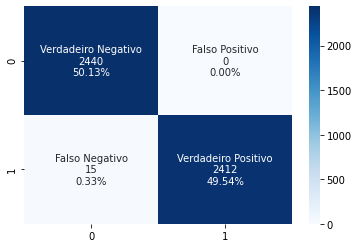

In [41]:
group_names = ['Verdadeiro Negativo','Falso Positivo','Falso Negativo','Verdadeiro Positivo']
group_counts = ['{0:0.0f}'.format(value) for value in mc_dt.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in mc_rf.flatten()/np.sum(mc_rf)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(mc_rf, annot=labels, fmt='', cmap='Blues')

In [42]:
# Exibição dos resultados
evaluator_rf = spark.createDataFrame(
    [(round(accuracy_rf,2), round(recall_rf,2), round(precision_rf,2), round(f1_rf,2),\
      int(fp_rf), int(fn_rf),\
      round(time_rf_train,2), round(time_rf_pred,2))],\
    ['acurácia','recall','precisão','f1 score',\
     'falso positivo', 'falso negativo',\
     'tempo treinamento','tempo predição'])
print("Resultados do modelo Random Forest:")
evaluator_rf.show()

Resultados do modelo Random Forest:
+--------+------+--------+--------+--------------+--------------+-----------------+--------------+
|acurácia|recall|precisão|f1 score|falso positivo|falso negativo|tempo treinamento|tempo predição|
+--------+------+--------+--------+--------------+--------------+-----------------+--------------+
|   99.67| 99.67|   99.67|   99.67|             0|            16|            10.01|          0.09|
+--------+------+--------+--------+--------------+--------------+-----------------+--------------+



In [43]:
result_rf.show(truncate = False, n = 5)

+-----+-------------------------------------+--------------------------------------+-----------------------------------------+----------+
|label|features                             |rawPrediction                         |probability                              |prediction|
+-----+-------------------------------------+--------------------------------------+-----------------------------------------+----------+
|0.0  |(7,[0,1,4],[1.0,10782.94,100585.0])  |[46.884291017466246,3.11570898253376] |[0.9376858203493248,0.062314179650675185]|0.0       |
|0.0  |(7,[0,1,4],[1.0,17851.54,32353.0])   |[46.55485970519186,3.445140294808147] |[0.9310971941038371,0.06890280589616293] |0.0       |
|0.0  |(7,[0,1,4],[1.0,26004.52,52251.58])  |[47.0295287281215,2.970471271878508]  |[0.9405905745624298,0.05940942543757015] |0.0       |
|0.0  |(7,[0,1,4],[1.0,47913.58,51304.0])   |[49.06861786549592,0.9313821345040785]|[0.9813723573099185,0.018627642690081568]|0.0       |
|0.0  |(7,[0,1,4],[1.0,193605.38,2

### Neural Network Perceptron (NNP)

In [44]:
# Treinamento do modelo de predição
start_time =  time.time()
layers = [7, 5, 5, 2]
trainer = MultilayerPerceptronClassifier(featuresCol='features', labelCol='label',\
          maxIter=100, layers=layers, blockSize=128, seed=1234)
model_nnp = trainer.fit(train)
time_nnp_train = time.time() - start_time

In [45]:
# Execução do modelo de predição na base de teste
start_time =  time.time()
result_nnp = model_nnp.transform(test)
time_nnp_pred = time.time() - start_time

In [46]:
# Cálculo da acurácia do modelo de predição
evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction',\
            metricName='accuracy')
accuracy_nnp = evaluator.evaluate(result_nnp) * 100

In [47]:
# Cálculo do recall do modelo de predição
evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction',\
            metricName='weightedRecall')
recall_nnp = evaluator.evaluate(result_nnp) * 100

In [48]:
# Cálculo da precisão do modelo de predição
evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction',\
            metricName='weightedPrecision')
precision_nnp = evaluator.evaluate(result_nnp) * 100

In [49]:
# Cálculo da F1 score do modelo de predição
evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction',\
            metricName='f1')
f1_nnp = evaluator.evaluate(result_nnp) * 100

In [50]:
# Matriz de confusão
y_true = result_nnp.select("label").toPandas()
y_pred = result_nnp.select("prediction").toPandas()
mc_nnp = confusion_matrix(y_true, y_pred)
tn_nnp, fp_nnp, fn_nnp, tp_nnp = confusion_matrix(y_true, y_pred).ravel()
print(mc_nnp)

[[2221  219]
 [  57 2370]]


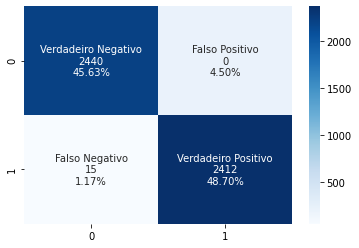

In [51]:
group_names = ['Verdadeiro Negativo','Falso Positivo','Falso Negativo','Verdadeiro Positivo']
group_counts = ['{0:0.0f}'.format(value) for value in mc_dt.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in mc_nnp.flatten()/np.sum(mc_nnp)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(mc_nnp, annot=labels, fmt='', cmap='Blues')

In [52]:
# Exibição dos resultados
evaluator_nnp = spark.createDataFrame(
    [(round(accuracy_nnp,2), round(recall_nnp,2), round(precision_nnp,2), round(f1_nnp,2),\
      int(fp_nnp), int(fn_nnp),\
      round(time_nnp_train,2), round(time_nnp_pred,2))],\
    ['acurácia','recall','precisão','f1 score',\
     'falso positivo', 'falso negativo',\
     'tempo treinamento','tempo predição'])
print("Resultados do modelo Neural Network Perceptron:")
evaluator_nnp.show()

Resultados do modelo Neural Network Perceptron:
+--------+------+--------+--------+--------------+--------------+-----------------+--------------+
|acurácia|recall|precisão|f1 score|falso positivo|falso negativo|tempo treinamento|tempo predição|
+--------+------+--------+--------+--------------+--------------+-----------------+--------------+
|   94.33| 94.33|   94.53|   94.32|           219|            57|            53.09|          0.07|
+--------+------+--------+--------+--------------+--------------+-----------------+--------------+



In [53]:
result_nnp.show(truncate = False, n = 5)

+-----+-------------------------------------+----------------------------------------+----------------------------------------+----------+
|label|features                             |rawPrediction                           |probability                             |prediction|
+-----+-------------------------------------+----------------------------------------+----------------------------------------+----------+
|0.0  |(7,[0,1,4],[1.0,10782.94,100585.0])  |[0.7711767786867174,0.2048427240060645] |[0.637916847820783,0.362083152179217]   |0.0       |
|0.0  |(7,[0,1,4],[1.0,17851.54,32353.0])   |[0.7711767786867174,0.2048427240060645] |[0.637916847820783,0.362083152179217]   |0.0       |
|0.0  |(7,[0,1,4],[1.0,26004.52,52251.58])  |[0.7711767786867174,0.2048427240060645] |[0.637916847820783,0.362083152179217]   |0.0       |
|0.0  |(7,[0,1,4],[1.0,47913.58,51304.0])   |[1.6647284287113397,-0.7801385349979125]|[0.9201852705430213,0.07981472945697869]|0.0       |
|0.0  |(7,[0,1,4],[1.0,1936

### Naive Bayes (NB)

In [54]:
# Treinamento do modelo de predição
start_time =  time.time()
trainer = NaiveBayes(smoothing=1.0, modelType='multinomial')
model_nb = trainer.fit(train)
time_nb_train = time.time() - start_time

In [55]:
# Execução do modelo de predição na base de teste
start_time =  time.time()
result_nb = model_nb.transform(test)
time_nb_pred = time.time() - start_time

In [56]:
# Cálculo da acurácia do modelo de predição
evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction',\
            metricName='accuracy')
accuracy_nb = evaluator.evaluate(result_nb) * 100

In [57]:
# Cálculo do recall do modelo de predição
evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction',\
            metricName='weightedRecall')
recall_nb = evaluator.evaluate(result_nb) * 100

In [58]:
# Cálculo da precisão do modelo de predição
evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction',\
            metricName='weightedPrecision')
precision_nb = evaluator.evaluate(result_nb) * 100

In [59]:
# Cálculo da F1 score do modelo de predição
evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction',\
            metricName='f1')
f1_nb = evaluator.evaluate(result_nb) * 100

In [60]:
# Matriz de confusão
y_true = result_nb.select("label").toPandas()
y_pred = result_nb.select("prediction").toPandas()
mc_nb = confusion_matrix(y_true, y_pred)
tn_nb, fp_nb, fn_nb, tp_nb = confusion_matrix(y_true, y_pred).ravel()
print(mc_nb)

[[1500  940]
 [ 309 2118]]


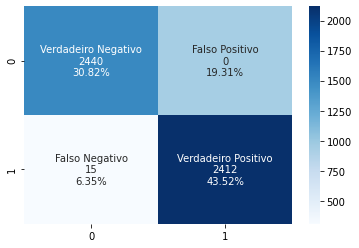

In [61]:
group_names = ['Verdadeiro Negativo','Falso Positivo','Falso Negativo','Verdadeiro Positivo']
group_counts = ['{0:0.0f}'.format(value) for value in mc_dt.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in mc_nb.flatten()/np.sum(mc_nb)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(mc_nb, annot=labels, fmt='', cmap='Blues')

In [62]:
# Exibição dos resultados
evaluator_nb = spark.createDataFrame(
    [(round(accuracy_nb,2), round(recall_nb,2), round(precision_nb,2), round(f1_nb,2),\
      int(fp_nb), int(fn_nb),\
      round(time_nb_train,2), round(time_nb_pred,2))],\
    ['acurácia','recall','precisão','f1 score',\
     'falso positivo', 'falso negativo',\
     'tempo treinamento','tempo predição'])
print("Resultados do modelo Naive Bayes:")
evaluator_nb.show()

Resultados do modelo Naive Bayes:
+--------+------+--------+--------+--------------+--------------+-----------------+--------------+
|acurácia|recall|precisão|f1 score|falso positivo|falso negativo|tempo treinamento|tempo predição|
+--------+------+--------+--------+--------------+--------------+-----------------+--------------+
|   74.34| 74.34|   76.11|   73.91|           940|           309|             6.05|          0.06|
+--------+------+--------+--------+--------------+--------------+-----------------+--------------+



In [63]:
result_nb.show(truncate = False, n = 5)

+-----+-------------------------------------+-----------------------------------------+-----------+----------+
|label|features                             |rawPrediction                            |probability|prediction|
+-----+-------------------------------------+-----------------------------------------+-----------+----------+
|0.0  |(7,[0,1,4],[1.0,10782.94,100585.0])  |[-182269.67865277277,-241851.82351438346]|[1.0,0.0]  |0.0       |
|0.0  |(7,[0,1,4],[1.0,17851.54,32353.0])   |[-112337.49642590462,-95769.90319682079] |[0.0,1.0]  |1.0       |
|0.0  |(7,[0,1,4],[1.0,26004.52,52251.58])  |[-170868.12565460312,-151134.76757259917]|[0.0,1.0]  |1.0       |
|0.0  |(7,[0,1,4],[1.0,47913.58,51304.0])   |[-251329.49680357386,-176358.5799792024] |[0.0,1.0]  |1.0       |
|0.0  |(7,[0,1,4],[1.0,193605.38,249452.05])|[-1075006.6392050763,-808275.1143704863] |[0.0,1.0]  |1.0       |
+-----+-------------------------------------+-----------------------------------------+-----------+----------+
o

### Logistic Regression (LR)

In [64]:
# Treinamento do modelo de predição
start_time =  time.time()
trainer = LogisticRegression(maxIter=10, tol=1E-6, fitIntercept=True)
model_lr = trainer.fit(train)
time_lr_train = time.time() - start_time

In [65]:
# Execução do modelo de predição na base de teste
start_time =  time.time()
result_lr = model_lr.transform(test)
time_lr_pred = time.time() - start_time

In [66]:
# Cálculo da acurácia do modelo de predição
evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction',\
            metricName='accuracy')
accuracy_lr = evaluator.evaluate(result_lr) * 100

In [67]:
# Cálculo do recall do modelo de predição
evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction',\
            metricName='weightedRecall')
recall_lr = evaluator.evaluate(result_lr) * 100

In [68]:
# Cálculo da precisão do modelo de predição
evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction',\
            metricName='weightedPrecision')
precision_lr = evaluator.evaluate(result_lr) * 100

In [69]:
# Cálculo da F1 score do modelo de predição
evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction',\
            metricName='f1')
f1_lr = evaluator.evaluate(result_lr) * 100

In [70]:
# Matriz de confusão
y_true = result_lr.select("label").toPandas()
y_pred = result_lr.select("prediction").toPandas()
mc_lr = confusion_matrix(y_true, y_pred)
tn_lr, fp_lr, fn_lr, tp_lr = confusion_matrix(y_true, y_pred).ravel()
print(mc_lr)

[[2437    3]
 [  64 2363]]


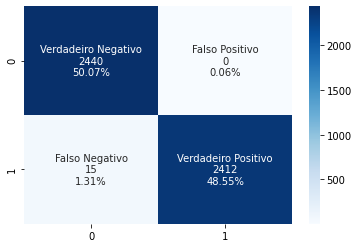

In [71]:
group_names = ['Verdadeiro Negativo','Falso Positivo','Falso Negativo','Verdadeiro Positivo']
group_counts = ['{0:0.0f}'.format(value) for value in mc_dt.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in mc_lr.flatten()/np.sum(mc_lr)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(mc_lr, annot=labels, fmt='', cmap='Blues')

In [72]:
# Exibição dos resultados
evaluator_lr = spark.createDataFrame(
    [(round(accuracy_lr,2), round(recall_lr,2), round(precision_lr,2), round(f1_lr,2),\
      int(fp_lr), int(fn_lr),\
      round(time_lr_train,2), round(time_lr_pred,2))],\
    ['acurácia','recall','precisão','f1 score',\
     'falso positivo', 'falso negativo',\
     'tempo treinamento','tempo predição'])
print("Resultados do modelo Logistic Regression:")
evaluator_lr.show()

Resultados do modelo Logistic Regression:
+--------+------+--------+--------+--------------+--------------+-----------------+--------------+
|acurácia|recall|precisão|f1 score|falso positivo|falso negativo|tempo treinamento|tempo predição|
+--------+------+--------+--------+--------------+--------------+-----------------+--------------+
|   98.62| 98.62|   98.65|   98.62|             3|            64|             8.81|          0.02|
+--------+------+--------+--------+--------------+--------------+-----------------+--------------+



In [73]:
result_lr.show(truncate = False, n = 5)

+-----+-------------------------------------+----------------------------------------+----------------------------------------+----------+
|label|features                             |rawPrediction                           |probability                             |prediction|
+-----+-------------------------------------+----------------------------------------+----------------------------------------+----------+
|0.0  |(7,[0,1,4],[1.0,10782.94,100585.0])  |[1.6632349203838523,-1.6632349203838523]|[0.8406717748203733,0.15932822517962675]|0.0       |
|0.0  |(7,[0,1,4],[1.0,17851.54,32353.0])   |[1.6721632731207916,-1.6721632731207916]|[0.8418640285420456,0.15813597145795436]|0.0       |
|0.0  |(7,[0,1,4],[1.0,26004.52,52251.58])  |[1.641626350124325,-1.641626350124325]  |[0.8377561136872689,0.1622438863127311] |0.0       |
|0.0  |(7,[0,1,4],[1.0,47913.58,51304.0])   |[1.5821045075587057,-1.5821045075587057]|[0.829502361107439,0.17049763889256095] |0.0       |
|0.0  |(7,[0,1,4],[1.0,1936

## Suport Vector Machines (SVM)

In [74]:
# Treinamento do modelo de predição
start_time =  time.time()
trainer = LinearSVC(featuresCol='features', labelCol='label',\
                    maxIter=100, regParam=0.1)
model_svm = trainer.fit(train)
time_svm_train = time.time() - start_time

In [75]:
# Execução do modelo de predição na base de teste
start_time =  time.time()
result_svm = model_svm.transform(test)
time_svm_pred = time.time() - start_time

In [76]:
# Cálculo da acurácia do modelo de predição
evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction',\
            metricName='accuracy')
accuracy_svm = evaluator.evaluate(result_svm) * 100

In [77]:
# Cálculo do recall do modelo de predição
evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction',\
            metricName='weightedRecall')
recall_svm = evaluator.evaluate(result_svm) * 100

In [78]:
# Cálculo da precisão do modelo de predição
evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction',\
            metricName='weightedPrecision')
precision_svm = evaluator.evaluate(result_svm) * 100

In [79]:
# Cálculo da F1 score do modelo de predição
evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction',\
            metricName='f1')
f1_svm = evaluator.evaluate(result_svm) * 100

In [80]:
# Matriz de confusão
y_true = result_svm.select("label").toPandas()
y_pred = result_svm.select("prediction").toPandas()
mc_svm = confusion_matrix(y_true, y_pred)
tn_svm, fp_svm, fn_svm, tp_svm = confusion_matrix(y_true, y_pred).ravel()
print(mc_svm)

[[2209  231]
 [ 123 2304]]


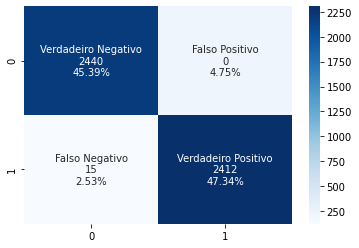

In [81]:
group_names = ['Verdadeiro Negativo','Falso Positivo','Falso Negativo','Verdadeiro Positivo']
group_counts = ['{0:0.0f}'.format(value) for value in mc_dt.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in mc_svm.flatten()/np.sum(mc_svm)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(mc_svm, annot=labels, fmt='', cmap='Blues')

In [82]:
# Exibição dos resultados
evaluator_svm = spark.createDataFrame(
    [(round(accuracy_svm,2), round(recall_svm,2), round(precision_svm,2), round(f1_svm,2),\
      int(fp_svm), int(fn_svm),\
      round(time_svm_train,2), round(time_svm_pred,2))],\
    ['acurácia','recall','precisão','f1 score',\
     'falso positivo', 'falso negativo',\
     'tempo treinamento','tempo predição'])
print("Resultados do modelo Suport Vector Machines:")
evaluator_svm.show()

Resultados do modelo Suport Vector Machines:
+--------+------+--------+--------+--------------+--------------+-----------------+--------------+
|acurácia|recall|precisão|f1 score|falso positivo|falso negativo|tempo treinamento|tempo predição|
+--------+------+--------+--------+--------------+--------------+-----------------+--------------+
|   92.73| 92.73|   92.81|   92.72|           231|           123|           585.06|          0.08|
+--------+------+--------+--------+--------------+--------------+-----------------+--------------+



In [83]:
result_svm.show(truncate = False, n = 5)

+-----+-------------------------------------+------------------------------------------+----------+
|label|features                             |rawPrediction                             |prediction|
+-----+-------------------------------------+------------------------------------------+----------+
|0.0  |(7,[0,1,4],[1.0,10782.94,100585.0])  |[-0.18166026181359599,0.18166026181359599]|1.0       |
|0.0  |(7,[0,1,4],[1.0,17851.54,32353.0])   |[-0.1860012133919604,0.1860012133919604]  |1.0       |
|0.0  |(7,[0,1,4],[1.0,26004.52,52251.58])  |[-0.1866648694328334,0.1866648694328334]  |1.0       |
|0.0  |(7,[0,1,4],[1.0,47913.58,51304.0])   |[-0.19084547190768078,0.19084547190768078]|1.0       |
|0.0  |(7,[0,1,4],[1.0,193605.38,249452.05])|[-0.2096398403889629,0.2096398403889629]  |1.0       |
+-----+-------------------------------------+------------------------------------------+----------+
only showing top 5 rows



## Resultados

In [84]:
models = ['Decision Tree','Random Forest','Neural Network Perceptron','Naive Bayes','Logistic Regression','Suport Vector Machines']

### Accuracy

In [85]:
print('Ranking Accuracy %')

list = ((models[0],accuracy_dt),\
        (models[1],accuracy_rf),\
        (models[2],accuracy_nnp),\
        (models[3],accuracy_nb),\
        (models[4],accuracy_lr),\
        (models[5],accuracy_nb))
df_acuracia = spark.createDataFrame(list, ['Modelo', 'Acuracia'])
df_acuracia.sort(df_acuracia.Acuracia.desc()).show(truncate = False)


Ranking Accuracy %
+-------------------------+-----------------+
|Modelo                   |Acuracia         |
+-------------------------+-----------------+
|Decision Tree            |99.69180193137457|
|Random Forest            |99.6712553934662 |
|Logistic Regression      |98.62338196013971|
|Neural Network Perceptron|94.32915553729197|
|Naive Bayes              |74.33737415245531|
|Suport Vector Machines   |74.33737415245531|
+-------------------------+-----------------+



### Recall

In [86]:
print('Ranking')

list = ((models[0],recall_dt),\
        (models[1],recall_rf),\
        (models[2],recall_nnp),\
        (models[3],recall_nb),\
        (models[4],recall_lr),\
        (models[5],recall_svm))
df_recall = spark.createDataFrame(list, ['Modelo', 'Recall'])
df_recall.sort(df_recall.Recall.desc()).show(truncate = False)

Ranking
+-------------------------+-----------------+
|Modelo                   |Recall           |
+-------------------------+-----------------+
|Decision Tree            |99.69180193137457|
|Random Forest            |99.6712553934662 |
|Logistic Regression      |98.62338196013971|
|Neural Network Perceptron|94.32915553729198|
|Suport Vector Machines   |92.7265255804397 |
|Naive Bayes              |74.33737415245531|
+-------------------------+-----------------+



### Precision

In [87]:
print('Ranking Precision %')

list = ((models[0],precision_dt),\
        (models[1],precision_rf),\
        (models[2],precision_nnp),\
        (models[3],precision_nb),\
        (models[4],precision_lr),\
        (models[5],precision_svm))
df_precision = spark.createDataFrame(list, ['Modelo', 'Precisao'])
df_precision.sort(df_precision.Precisao.desc()).show(truncate = False)

Ranking Precision %
+-------------------------+-----------------+
|Modelo                   |Precisao         |
+-------------------------+-----------------+
|Decision Tree            |99.69368501529692|
|Random Forest            |99.67339705214069|
|Logistic Regression      |98.65386541768162|
|Neural Network Perceptron|94.52742561372798|
|Suport Vector Machines   |92.8116914357235 |
|Naive Bayes              |76.1080875663157 |
+-------------------------+-----------------+



### F1 score

In [88]:
list = ((models[0],f1_dt),\
        (models[1],f1_rf),\
        (models[2],f1_nnp),\
        (models[3],f1_nb),\
        (models[4],f1_lr),\
        (models[5],f1_svm))
df_f1 = spark.createDataFrame(list, ['Modelo', 'F1'])
df_f1.sort(df_f1.F1.desc()).show(truncate = False)

+-------------------------+-----------------+
|Modelo                   |F1               |
+-------------------------+-----------------+
|Decision Tree            |99.69179646661719|
|Random Forest            |99.67124895371123|
|Logistic Regression      |98.62311956684768|
|Neural Network Perceptron|94.32337146710331|
|Suport Vector Machines   |92.72337397325676|
|Naive Bayes              |73.907980556053  |
+-------------------------+-----------------+



### Tempo de Treinamento

In [89]:
list = ((models[0],time_dt_train),\
        (models[1],time_rf_train),\
        (models[2],time_nnp_train),\
        (models[3],time_nb_train),\
        (models[4],time_lr_train),\
        (models[5],time_svm_train))
df_time_train = spark.createDataFrame(list, ['Modelo', 'Tempo_Treinamento'])
df_time_train.sort(df_time_train.Tempo_Treinamento.asc()).show(truncate = False)

+-------------------------+------------------+
|Modelo                   |Tempo_Treinamento |
+-------------------------+------------------+
|Naive Bayes              |6.047499179840088 |
|Logistic Regression      |8.806694507598877 |
|Decision Tree            |8.950883865356445 |
|Random Forest            |10.0124351978302  |
|Neural Network Perceptron|53.085105895996094|
|Suport Vector Machines   |585.063728094101  |
+-------------------------+------------------+



### Tempo de Predição

In [90]:
list = ((models[0],time_dt_pred),\
        (models[1],time_rf_pred),\
        (models[2],time_nnp_pred),\
        (models[3],time_nnp_pred),\
        (models[4],time_nnp_pred),\
        (models[5],time_nnp_pred))
df_time_pred = spark.createDataFrame(list, ['Modelo', 'Tempo_Predicao'])
df_time_pred.sort(df_time_pred.Tempo_Predicao.asc()).show(truncate = False)

+-------------------------+-------------------+
|Modelo                   |Tempo_Predicao     |
+-------------------------+-------------------+
|Neural Network Perceptron|0.0682060718536377 |
|Naive Bayes              |0.0682060718536377 |
|Logistic Regression      |0.0682060718536377 |
|Suport Vector Machines   |0.0682060718536377 |
|Decision Tree            |0.08316850662231445|
|Random Forest            |0.0926060676574707 |
+-------------------------+-------------------+



### Falso Positivo

In [91]:
list = ((models[0],int(fp_dt)),\
        (models[1],int(fp_rf)),\
        (models[2],int(fp_nnp)),\
        (models[3],int(fp_nb)),\
        (models[4],int(fp_lr)),\
        (models[5],int(fp_svm)))
df_fp = spark.createDataFrame(list, ['Modelo', 'Falso_Positivo'])
df_fp.sort(df_fp.Falso_Positivo.asc()).show(truncate = False)

+-------------------------+--------------+
|Modelo                   |Falso_Positivo|
+-------------------------+--------------+
|Random Forest            |0             |
|Decision Tree            |0             |
|Logistic Regression      |3             |
|Neural Network Perceptron|219           |
|Suport Vector Machines   |231           |
|Naive Bayes              |940           |
+-------------------------+--------------+



### Falso Negativo

In [92]:
list = ((models[0],int(fn_dt)),\
        (models[1],int(fn_rf)),\
        (models[2],int(fn_nnp)),\
        (models[3],int(fn_nb)),\
        (models[4],int(fn_lr)),\
        (models[5], int(fn_svm)))
df_fn = spark.createDataFrame(list, ['Modelo', 'Falso_Negativo'])
df_fn.sort(df_fn.Falso_Negativo.asc()).show(truncate = False)

+-------------------------+--------------+
|Modelo                   |Falso_Negativo|
+-------------------------+--------------+
|Decision Tree            |15            |
|Random Forest            |16            |
|Neural Network Perceptron|57            |
|Logistic Regression      |64            |
|Suport Vector Machines   |123           |
|Naive Bayes              |309           |
+-------------------------+--------------+



### Comparativo

In [93]:
df = df_acuracia.join(df_fp, "Modelo")
df = df.join(df_fn, "Modelo")
df = df.join(df_time_train, "Modelo")
df = df.join(df_time_pred, "Modelo")
df.sort(df.Acuracia.desc()).show(truncate = False)

+-------------------------+-----------------+--------------+--------------+------------------+-------------------+
|Modelo                   |Acuracia         |Falso_Positivo|Falso_Negativo|Tempo_Treinamento |Tempo_Predicao     |
+-------------------------+-----------------+--------------+--------------+------------------+-------------------+
|Decision Tree            |99.69180193137457|0             |15            |8.950883865356445 |0.08316850662231445|
|Random Forest            |99.6712553934662 |0             |16            |10.0124351978302  |0.0926060676574707 |
|Logistic Regression      |98.62338196013971|3             |64            |8.806694507598877 |0.0682060718536377 |
|Neural Network Perceptron|94.32915553729197|219           |57            |53.085105895996094|0.0682060718536377 |
|Naive Bayes              |74.33737415245531|940           |309           |6.047499179840088 |0.0682060718536377 |
|Suport Vector Machines   |74.33737415245531|231           |123           |585.0

## Teste de classificação do melhor modelo

In [94]:
df_selecionado.show(1)

+----+-------+-------------+--------------+--------------+--------------+---------+-----+
|step| amount|oldbalanceOrg|newbalanceOrig|oldbalanceDest|newbalanceDest|indexType|label|
+----+-------+-------------+--------------+--------------+--------------+---------+-----+
|   1|1864.28|      21249.0|      19384.72|           0.0|           0.0|      2.0|  0.0|
+----+-------+-------------+--------------+--------------+--------------+---------+-----+
only showing top 1 row



In [95]:
#valores de entrada e saída para teste
entradas = [1.0, 9839.64,170136.0, 160296.36,0.0,0.0,2.0]
resultado = 0.0

In [96]:
#criando o dataframe Spark para execução do modelo
df_teste = spark.createDataFrame(
    [(resultado,\
      Vectors.dense([entradas[0],entradas[1],entradas[2],entradas[3],entradas[4],entradas[5],entradas[6]]))],
    ['label', 'features'])

In [97]:
#resultado da predição utilizando o modelo RF
resultado = model_rf.transform(df_teste)
resultado.select('label','prediction').show()

+-----+----------+
|label|prediction|
+-----+----------+
|  0.0|       0.0|
+-----+----------+



In [98]:
spark.stop()